In [362]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
import emcee
rcParams['figure.figsize'] = 12, 9

## Neyman construction

В общем случае, построить доверительный интервал в частотном подходе является крайне нетривиальной задачей. Джази Нейман предложил умеренно упрощенный способ. 

Для всех возможных значений параметров $\theta$

* Определяют интервал $\hat{\theta}_1(\theta)$ и $\hat{\theta}_2(\theta)$, вероятность попадания в который равна $1-\alpha$ (confidence level). Данный шаг определит нам confidence belt.
$$
\int_{x_1(\theta)}^{x_2(\theta)} f(\hat{\theta}|\theta) \, d\hat{\theta} = 1 - \alpha
$$
* Далее для конкретного наблюдения $\hat{\theta}_{obs}$ мы инвертируем confidence belt, чтобы получить для этого значения $\theta_l(\hat{\theta}_{obs})$ и $\theta_u(\hat{\theta}_{obs})$, которые и определят нам этот интервал.


Рассмотрим это на примере нормального распределения. Пусть мы знаем, что события распределены по нормальному закону с неизвестными $\mu$ и известным $\sigma^2$, тогда

$$
\hat{\mu} \sim \mathcal{N} \left(\hat{\mu} | \mu, \frac{\sigma^2}{N} \right)
$$

Откуда для первого шага мы получаем: $\hat{\mu}$ попадает в интервал $[\mu - \sigma, \mu + \sigma]$ с вероятностью 68.3%. Для второго шага: $\hat{\mu} \pm \sigma$. 

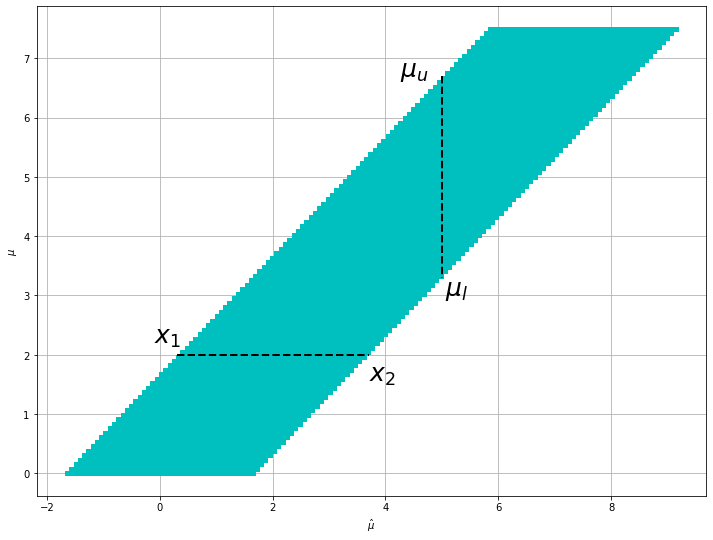

In [314]:
from scipy.stats import norm

# Возможные значения для среднего
mus = np.linspace(0, 7.5, 100)
sigma2 = 1

# Покрытие 90%
alpha = 0.1

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")
for mu in mus:
    pdf = norm(mu, np.sqrt(sigma2))
    hmu1 = pdf.ppf(alpha/2)
    hmu2 = pdf.ppf(1 - alpha/2)
    plt.plot([hmu1, hmu2], [mu, mu], 'c-', lw=5)
    
plt.grid()
#plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], "r-", lw=2)
plt.plot([0.3, 3.7], [2, 2], 'k--', lw=2)
plt.text(-0.1, 2.2, "$x_1$", fontsize=25)
plt.text(3.7, 1.55, "$x_2$", fontsize=25)

plt.plot([5, 5], [6.7, 3.3], 'k--', lw=2)
plt.text(4.25, 6.7, "$\mu_u$", fontsize=25)
plt.text(5.05, 3., "$\mu_l$", fontsize=25)
plt.show()

При этом, ничего не мешает нам строить вместо симметричных интервалов односторонние.

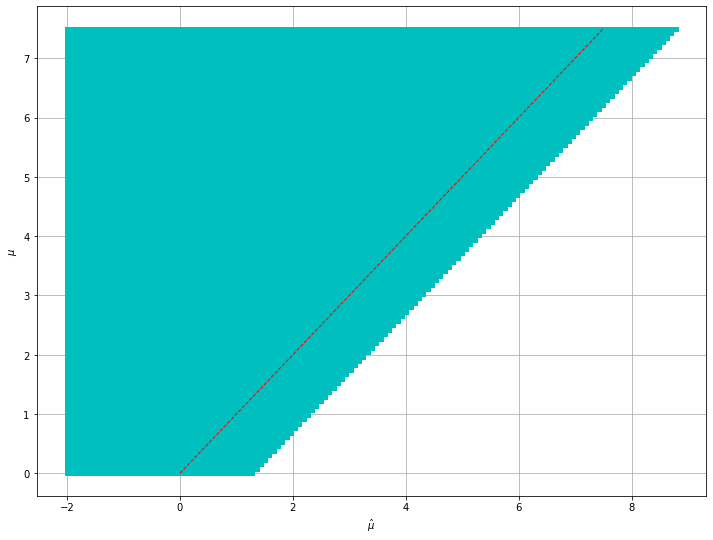

In [175]:
from scipy.stats import norm

# Возможные значения для среднего
mus = np.linspace(0, 7.5, 100)
sigma2 = 1

# Покрытие 90%
alpha = 0.1

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")
for mu in mus:
    pdf = norm(mu, np.sqrt(sigma2))
    hmu1 = -2
    hmu2 = pdf.ppf(1 - alpha)
    plt.plot([hmu1, hmu2], [mu, mu], 'c-', lw=5)
    
plt.grid()
plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], "r--", lw=1)

plt.show()

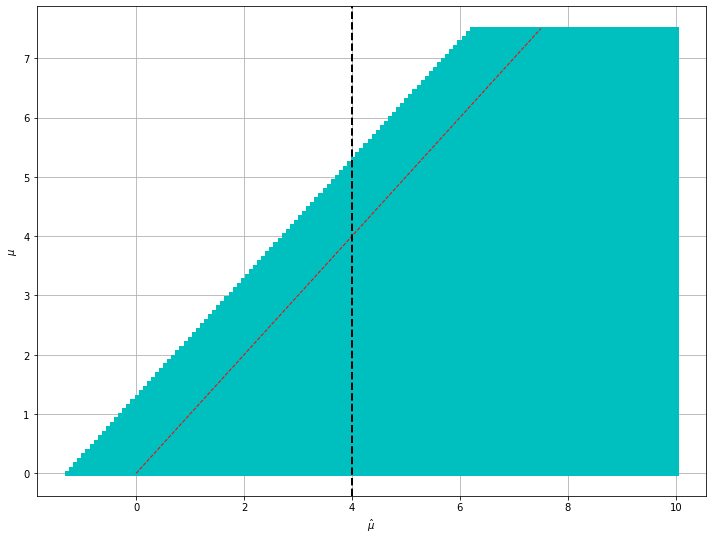

In [201]:
from scipy.stats import norm

# Возможные значения для среднего
mus = np.linspace(0, 7.5, 100)
sigma2 = 1

# Покрытие 90%
alpha = 0.1

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")
for mu in mus:
    pdf = norm(mu, np.sqrt(sigma2))
    hmu1 = pdf.ppf(alpha)
    hmu2 = 10
    plt.plot([hmu1, hmu2], [mu, mu], 'c-', lw=5)
    
plt.grid()
plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], "r--", lw=1)
plt.axvline(4, c='k', lw=2, ls='--')

plt.show()

В общем случае, это могут быть довольно сложные многомерные области или просто множество единичных точек.

## Приближенное решение для доверительного интервала

Мы можем разложить логарифмическую функцию правдоподобия в окрестности её максимума

$$
\ln L(\theta| \mathbf{X}) = \ln L(\hat{\theta}|\mathbf{X}) + \frac{1}{2} \left.\frac{\partial^2 \ln L}{\partial \theta^2}\right|_{\theta=\hat{\theta}} (\theta - \hat{\theta})^2 + \ldots
$$

Член разложения соответствующий $(\hat{\theta} - \theta)$ очевидно равен 0 (условие максимума). Если оставить члены до второй степени включительно, то мы фактически пытаемся приблизить правдоподобие параболлой, которая соответствует нормальному распределению. В случае нескольких переменных, мы получим просто многомерное нормальное распределение.

Раз мы теперь знаем, что это приближенный Гаусс, то сразу же можем попробовать определить область, куда попадает $x$ с вероятностью $1-\alpha$. Для уровня в $1\sigma$ мы увидим, что показатель экспоненты равен $-\frac{1}{2}$. А значит мы можем посмотреть на область, которая ограничена этим уровнем.

Рассмотрим простой Гаусс с известным $\sigma^2$

$$
\ln L(\mu) = const - \frac{1}{2\sigma^2} \sum_n (x_n - \mu)^2
\\
\frac{\partial \ln L}{\partial \mu} = \frac{1}{\sigma^2} \sum_n (x_n - \mu)
\\
\frac{\partial^2 \ln L}{\partial \mu^2} = -\frac{N}{\sigma^2} 
\\
\hat{\mu} = \frac{1}{N} \sum_n x_n
$$

Отсюда (здесь формула точная)

$$
\ln L = \ln L(\hat{\mu}) - \frac{N}{2\sigma^2} (\mu - \hat{\mu})^2
\\
\ln \left(\frac{ L(\mu)}{L(\hat{\mu})} \right) = - \frac{N}{2\sigma^2} (\mu - \hat{\mu})^2
$$

Уровень экспонеты в $-\frac{1}{2}$

$$
\frac{N}{2\sigma^2} (\mu - \hat{\mu})^2 = \frac{1}{2}
\\
(\mu - \hat{\mu})^2 = \frac{\sigma^2}{N}
\\
\mu = \hat{\mu} \pm \frac{\sigma}{\sqrt{N}}
$$

Что опять таки совпадает с известным нам результатом. В общем случае, это будет просто давать разумное приближение. При этом мы можем выбрать и другой уровень, например -2 будет соответстсовать $2\sigma$, а -9/2 будет соответствовать $3\sigma$.

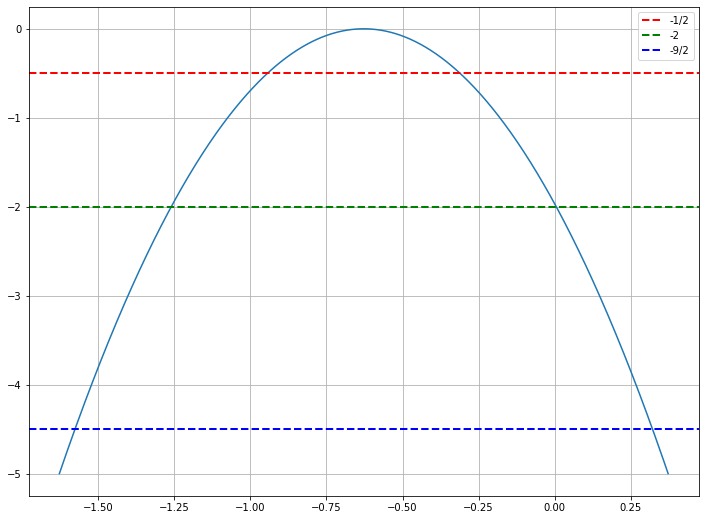

In [199]:
from scipy.stats import norm

N = 10
samples = norm.rvs(size = N)

mean = samples.mean()

mu = np.linspace(mean-1, mean+1, 1000)
lnL = -N / 2 * (mu - mean)**2

plt.grid()
plt.plot(mu, lnL)
plt.axhline(-1/2, c='r', lw=2, ls='--', label="-1/2")
plt.axhline(-2, c='g', lw=2, ls='--', label="-2")
plt.axhline(-9/2, c='b', lw=2, ls='--', label="-9/2")
plt.legend()
plt.show()

В случае нескольких параметров - это будет многомерный эллипс.

## Перенос ошибки

Иногда нам может захотеться перейти от одной случайной величины $\vec{x}$ к другой случайной величине, которая является функцией оригинальной случайной величины $\vec{h}(\vec{x})$. 

Как мы можем это сделать? 

Довольно просто, мы помним, что функция плотности вероятности нормированна на 1, а значит, чтобы сохранить это значение, нам нужно использовать стандартный подход - изменить переменные интегриорвания, что приводит к тому, что функцию плотности вероятности достаточно просто умножить на модуль якобиана.

Поэтому в некоторых источниках не используют термин "Перенос ошибок", а просто называют это заменной переменных.


Пусть у нас есть $f(x, y)$ и мы хотим перейти к $h_1(x, y)$ и $h_2(x, y)$, тогда 

$$
f(h_1, h_2) = f(x, y) \left| \frac{D(x,y)}{D(h_1, h_2)}\right|
$$

В альтернативном подходе мы вместо точного решения, можем попробовать найти приближенное. Пусть у нас есть независимые случайные величины $x_1, x_2, x_3, \ldots, x_K$ и функция этих случайных величин $h(x_1, \ldots, x_K)$, то разложение в ряд Тейлора в окрестности $\vec{\mu}$ примет вид

$$
h(\vec{x}) 
\approx 
h(\vec{\mu}) 
+ 
\sum_k (x_k - \mu_k)\left.\frac{\partial h}{\partial x_k} \right|_{\vec{x} = \vec{\mu}} 
+ 
\ldots
\\
E[x_i] = \mu_i
\\
D[x_i] = \sigma_i
$$

Отсюда легко найти, что матожидание

$$
E[h(\vec{x})] \approx h(\vec{\mu})
$$

Помня, что мы складываем независимые случайные величины, а это значит 

$$
Cov(x_i, x_j) = E[(x_i - \mu_i)(x_j - \mu_j)] = 0 
$$ 

для всех $i \ne j$.

Тогда дисперсия

$$
D[h(\vec{x})] 
\approx 
E[ (h(\vec{x}) - E[h(\vec{x})])^2 ] 
= 
E[ (h(\vec{x}) - h(\vec{\mu}))^2 ]
= \\ =
E\left[
    \left(
        \sum_k (x_k - \mu_k)\left.\frac{\partial h}{\partial x_k} \right|_{\vec{x} = \vec{\mu}}
    \right)^2
\right]
= \\ =
E\left[
    \sum_k (x_k - \mu_k)^2 \left( \left.\frac{\partial h}{\partial x_k} \right|_{\vec{x} = \vec{\mu}} \right)^2
\right]
= \\ =
\sum_k \left( \left.\frac{\partial h}{\partial x_k} \right|_{\vec{x} = \vec{\mu}} \right)^2 E\left[
     (x_k - \mu_k)^2 
\right] 
=
\sum_k \left( \left.\frac{\partial h}{\partial x_k} \right|_{\vec{x} = \vec{\mu}} \right)^2 D[x_k] 
=
\sum_k \left( \left.\frac{\partial h}{\partial x_k} \right|_{\vec{x} = \vec{\mu}} \right)^2 \sigma^2_k
$$

Если случайные величины будут зависимы, то ковариация уже не будет равна нулю и просто представить в виде суммы дисперсию не получится

$$
D[h(\vec{x})] \approx \sum_i \sum_j \left(\left.\frac{\partial h}{\partial x_i} \right|_{\vec{x} = \vec{\mu}}\right) \left( \left.\frac{\partial h}{\partial x_j} \right|_{\vec{x} = \vec{\mu}} \right) Cov[x_i, x_j]
$$

Где матрицу $Cov[x_i, x_j]$ называют матрицей ошибок.

## Линейные комбинации случайных величин

Одним из важных классов функций случайной величины - это линейная комбинация независимых случайных величин

$$
h(\vec{x}) = \sum_k a_k x_k
$$

Легко показать, используя знание о том, что матожидание - это линейный операторв:

$$
E[h(\vec{x})] = \sum_k a_k E[x_k] = \sum_k a_k \mu_k
\\
D[h(\vec{x})] = E[ (h(\vec{x}) - E[h(\vec{x})])^2 ] = E[ (h(\vec{x}) - h(\vec{\mu}))^2 ] = \sum_k a_k^2 \sigma_k^2
$$

## Проблемы

Помимо того, что сам по себе доверительный интервал порой сложно построить, есть еще проблемы с ним. Допустим, мы считаем, что  $\mu \ge 0$. И здесь начинаются проблемы.

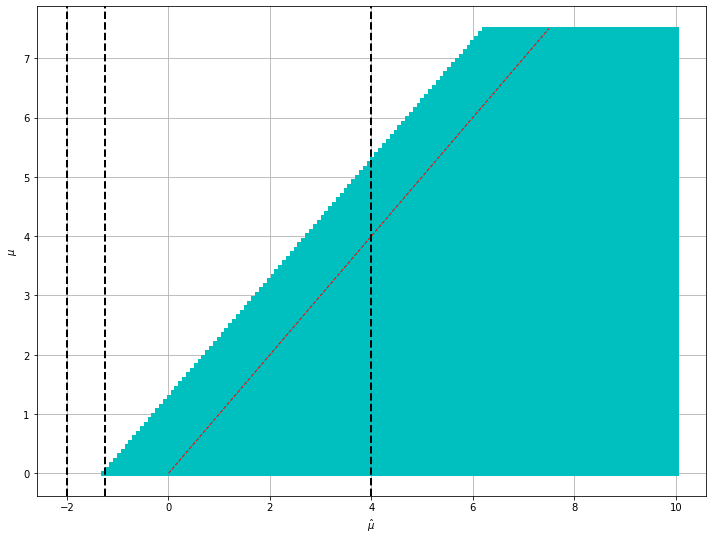

In [200]:
from scipy.stats import norm

# Возможные значения для среднего
mus = np.linspace(0, 7.5, 100)
sigma2 = 1

# Покрытие 90%
alpha = 0.1

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")
for mu in mus:
    pdf = norm(mu, np.sqrt(sigma2))
    hmu1 = pdf.ppf(alpha)
    hmu2 = 10
    plt.plot([hmu1, hmu2], [mu, mu], 'c-', lw=5)
    
plt.grid()
plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], "r--", lw=1)
plt.axvline(4, c='k', lw=2, ls='--')
plt.axvline(-2, c='k', lw=2, ls='--')
plt.axvline(-1.25, c='k', lw=2, ls='--')

plt.show()

Для $\hat{\mu} = 4$ все в целом неплохо $0 \ge \mu \ge 5.35$. Для $\hat{\mu} = -1.25$ интервал вообще получится маленьким $0 \ge \mu \ge 0.1$, что очень странно. Мы измерили нефизичное значение, а получили доверительный интервал значительно уже, чем физичном значении. Для $\hat{\mu} = -2$ данный интервал вообще должен быть отрицательным, но не может.

И еще раз напоминаю, доверительный интервал в частотном подходе рассматривается только на гипотетическом большом количестве экспериментов. Таким образом, в $1-\alpha$ процентах экспериментах, доверительный интервал накроет истинное значение. Для $\hat{\mu} = -2$ фактически мы будем знать, что невозможно построить доверительный интервал с указанным уровнем значимости.


Теперь представим экспериментатора, который думает следующее
> Я ищу какой-то новый эффект, но я точно не знаю, существует это значение или нет. Если данного значения нет, то я просто сообщу верхний предел на это значение (например, как сделано с массой фотона). Если это значение есть, то я укажу измеренное значение с верхним и нижним пределом на это значение. И я без понятия в каком конкретно случае я нахожусь. И так, я посмотрю на данные, что у меня есть. Если эффект имеет ненулевое значение со значением более $3\sigma$, то я указывают обычный доверительный интервал. Если менее $3\sigma$, то указываю просто верхную границу. Более того, если я измерил нефизичное значение (отрицательное), то я просто говорю, что измерил 0.

По сути, мы склеиваем две области, основываясь на наблюдаемом значении.

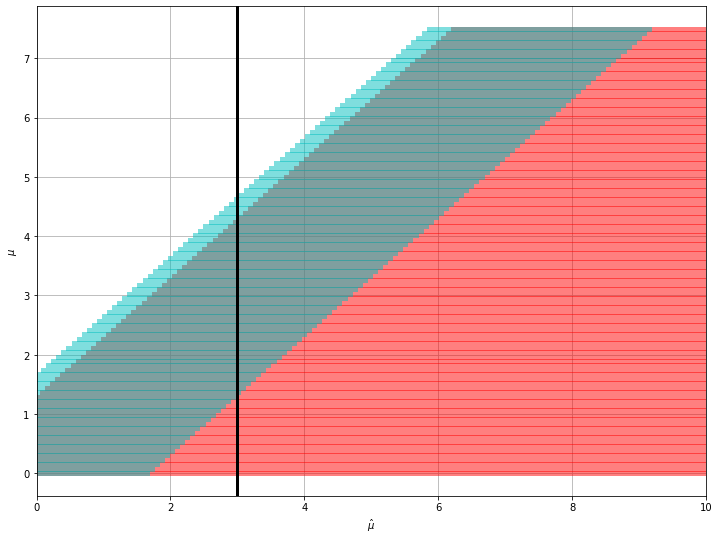

In [86]:
from scipy.stats import norm

# Возможные значения для среднего
mus = np.linspace(0, 7.5, 100)
sigma2 = 1

# Покрытие 90%
alpha = 0.1

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")

for mu in mus:
    pdf = norm(mu, np.sqrt(sigma2))
    hmu1 = pdf.ppf(alpha)
    hmu2 = 10
    plt.plot([hmu1, hmu2], [mu, mu], 'r-', alpha=0.5, lw=5)
    
for mu in mus:
    pdf = norm(mu, np.sqrt(sigma2))
    hmu1 = pdf.ppf(alpha/2)
    hmu2 = pdf.ppf(1 - alpha/2)
    plt.plot([hmu1, hmu2], [mu, mu], 'c-', alpha=0.5, lw=5)
    
plt.xlim(0, 10)
plt.axvline(3, ls='-', lw=3, c='k')
plt.grid()
plt.show()

Если измеренное значение $\hat{\mu}$ левее черной черты, мы берем красную область. если правее - голубую.

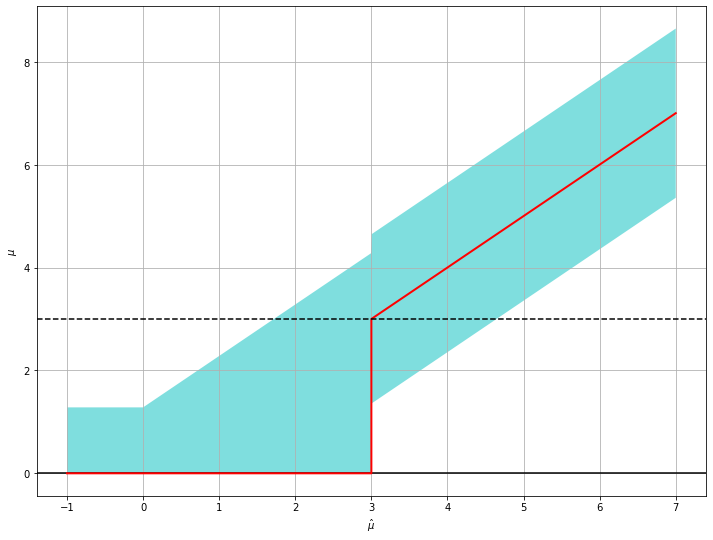

In [89]:
from scipy.stats import norm

# Возможные значения для среднего
mus = np.linspace(-1, 7, 1000)
sigma2 = 1
alpha = 0.10

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")

mut = []
mub = []
x = []
for mu in mus:
    x.append(mu)
    
    if mu < 0:
        mu = 0
    pdf = norm(mu, np.sqrt(sigma2))

    m_bot = pdf.ppf(alpha/2)
    m_top = pdf.ppf(1 - alpha/2)

    if mu < 3:
        m_bot = 0
        m_top = pdf.ppf(1 - alpha)
        
    mut.append(m_top)
    mub.append(m_bot)
    
    
mut = np.array(mut)
mub = np.array(mub)
    
plt.grid()
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([mut, mub[::-1]]),
         alpha=.5, fc='c', label="31.7%")
plt.axhline(0, c="k")
plt.plot([-1, 3, 3, mus.max()], [0, 0, 3, mus.max()], "r-", lw=2)

plt.axhline(3, c="k", ls='--')
plt.show()


Здесь можно увидеть, что данный подход дает неправильное покрытие для измеряемых величин $\hat{\mu}$ при фиксированном $\mu$.

## Feldman & Cousins

Они предложили формировать доверительный интервал чуть более сложным способом, чем Neyman Construction. Они предложили сдвигать границы допустимых значений наблюдаемого параметра исходя из истинного значения этого параметра. Для этого был введен новый критерий определения границ

$$
\lambda(\hat{\mu}|\mu) = \frac{f(\hat{\mu} | \mu)}{f(\hat{\mu}|\mu_{best})}
$$

Для этого критерия вводят пороговое значение $k_\alpha$, которое из условия 

$$
\lambda(\hat{\mu}|\mu) < k_\alpha
$$

при фиксированном $\mu$ определит нам область значений $R_\alpha = \{\hat{\mu}: \lambda(\hat{\mu}|\mu) < k_\alpha \}$

$$
\int_{R_\alpha} f(\hat{\mu} | \mu) \, d\hat{\mu} = 1 - \alpha
$$


Попробуем это понять на примере Гаусса ($\sigma = 1$)

$$
f(\hat{\mu} | \mu) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(\hat{\mu} - \mu)^2}{2}}
$$

В этом случае $\mu_{best}$ будет (помним, что для нефизичных значених мы ставим 0)

$$
\mu_{best} = \max(0, \hat{\mu})
$$

Откуда

$$
f(\hat{\mu}|\mu_{best}) = \left\{\begin{align}
&\frac{1}{\sqrt{2\pi}}, &\hat{\mu} \ge 0
\\
&\frac{1}{\sqrt{2\pi}} e^{-\frac{\hat{\mu}^2}{2}}, &\hat{\mu} < 0
\end{align}\right.
$$

и

$$
\lambda(\hat{\mu}|\mu) = \left\{\begin{align}
&\exp\left[-\frac{(\hat{\mu}-\mu)^2}{2}\right], &\hat{\mu} \ge 0
\\
&\exp\left[-\frac{\mu^2- 2\hat{\mu} \mu}{2}\right], &\hat{\mu} < 0
\end{align}\right.
$$

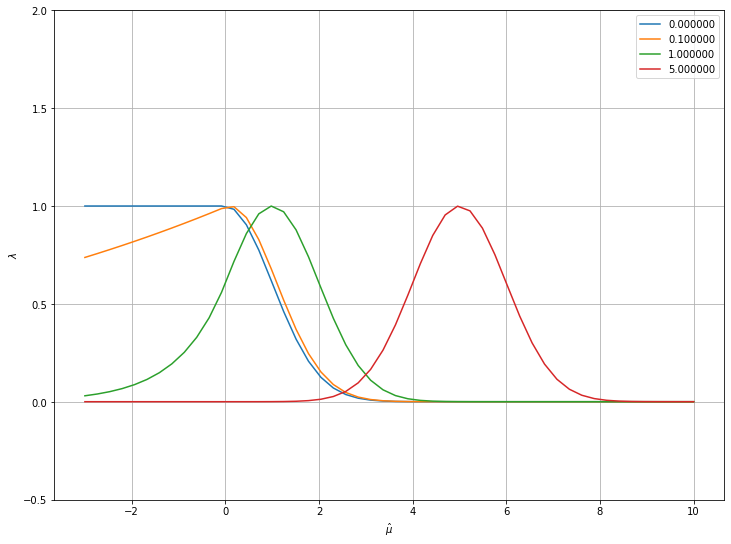

In [229]:
def Lam(hm, m):
    return np.where(hm >= 0, np.exp(-(hm - m)**2 / 2), np.exp(-(m*m - 2*hm *m) / 2))
    
hm = np.linspace(-3, 10)
for m in [0, 0.1, 1, 5]:
    y = Lam(hm, m)
    plt.plot(hm, y, label="%f" % m)
    
plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\lambda$")
plt.grid()
plt.ylim(-0.5, 2)
plt.legend()
plt.show()

Дальще расчитать получится только численно. Например для $\hat{\mu} \le 0$ - это будет односторонная область, определяемая верхним пределом. При достаточно больших $\hat{\mu}$ - это будет классический симметричный доверительный интервал. 

$$
\ln \lambda(\hat{\mu}|\mu) = \left\{\begin{aligned}
&-\frac{(\hat{\mu}-\mu)^2}{2}, &\hat{\mu} \ge 0
\\
&-\frac{\mu^2- 2\hat{\mu} \mu}{2}, &\hat{\mu} < 0
\end{aligned}\right.
$$

$$
\hat{\mu} = \mu \pm \sqrt{-2k}
\\
\hat{\mu} = \frac{\mu^2 + 2k}{2\mu}
$$

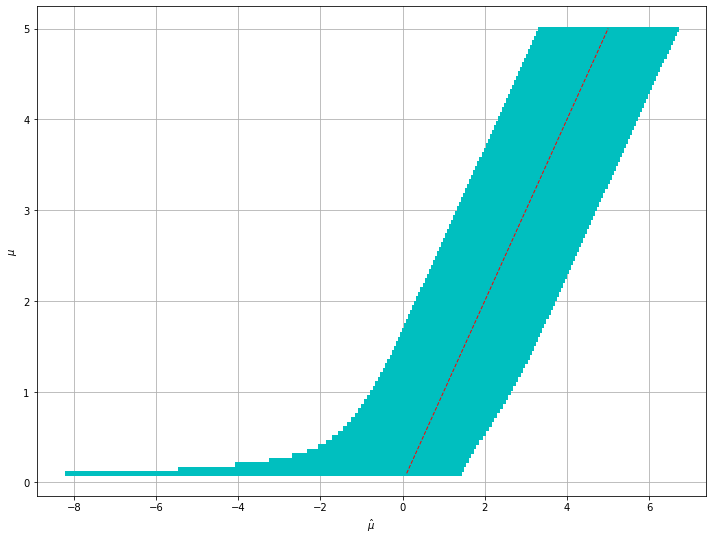

In [246]:
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import brentq

def lnLam(hm, m):
    return np.where(hm >= 0, -(hm - m)**2 / 2, -(m*m - 2*hm *m) / 2)

# Определяет краевые точки для hat mu
def Inter(k, m):
    roots = []
    
    if m < 0:
        return None, None
    
    if m != 0:
        r = (m * m  + 2 * k) / 2 / m
        if r <= 0:
            roots.append(r)
            
    if k <= 0:
        if m - np.sqrt(-2 * k) >= 0:
            roots.append(m - np.sqrt(-2 * k))

        if m + np.sqrt(-2 * k) >= 0:
            roots.append(m + np.sqrt(-2 * k))
       
    if len(roots) == 0:
        return None, None
    
    if m <= 0:
        return None, min(roots)
    else:
        return min(roots), max(roots)
    
def Pair(m, alpha):
    m1s = []
    m2s = []
    p = []
    pdf = norm(m)
    for k in np.linspace(0.0001, 0.9999, 100):
        m1, m2 = Inter(np.log(k), m)
        m1s.append(m1)
        m2s.append(m2)
        p.append(pdf.cdf(m2) - pdf.cdf(m1) - (1 - alpha))
 
    pf =  interp1d([n for n in range(0, len(p))], p)
    m1f = interp1d([n for n in range(0, len(p))], m1s)
    m2f = interp1d([n for n in range(0, len(p))], m2s)
    root = brentq(pf, 0, len(p)-1)
    
    return m1f(root), m2f(root)
        
    
# Возможные значения для среднего
mus = np.linspace(0.1, 5, 100)

# Покрытие 90%
alpha = 0.1

plt.xlabel("$\hat{\mu}$")
plt.ylabel("$\mu$")
for mu in mus:
    hmu1, hmu2 = Pair(mu, alpha)
    plt.plot([hmu1, hmu2], [mu, mu], 'c-', lw=5)
    
plt.grid()
plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], "r--", lw=1)

plt.show()

Или чуть более красивый рисунок

<img src="nc.png">

В этом случае мы всегда получаем адекватное покрытие для измеряемой величины, также как и для любой измеренной величины мы получаем ненулевой доверительный интервал. Также имеется плавный переход от двухстороннего интервала к одностороннему.

## Вспомогательные параметры (Nuisance parameters)

В идеальном мире наше распределение выглядело бы как на бумаге. В реальном миру, мы должны встретиться с ограниченной возможностью нашего познания и ошибками измерительных приборов.

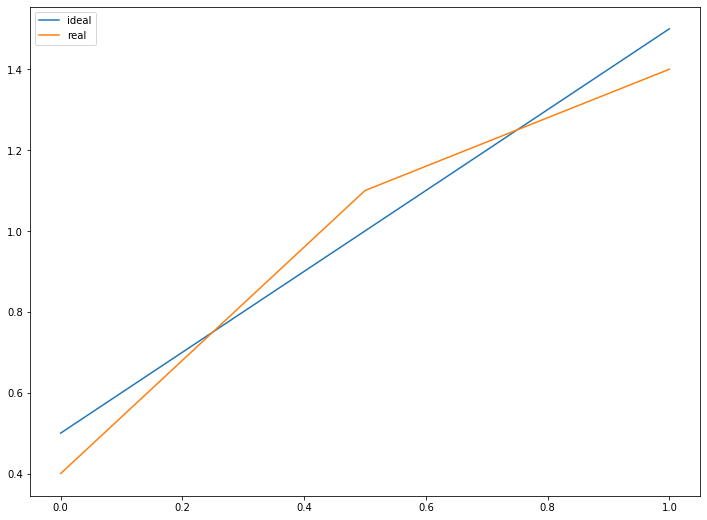

In [248]:
plt.plot([0, 1], [0.5, 1.5], label="ideal")
plt.plot([0, 0.5, 1], [0.4, 1.1, 1.4], label="real")
plt.legend()
plt.show()

Для учета всех этих особенностей, мы переходим к более сложным вероятностным распределениям, что приводит к тому, что число параметров нашего распределения растет. При этом, нас по сути, может интересовать лишь только один параметр, остальные для нас интереса не представляют. Например, мы хотим измерить скорость света, при этом нас не сильно интересует точные оценки на все внутренние параметры прибора. 

Все параметры распределения, которые нас не интересуют - называются вспомогательными (nuisance).

$$
f(\mathbf{X} | \vec{\theta}, \vec{\eta})
$$

где $\vec{\theta}$ - параметры, которые нам бы хотелось найти, $\vec{\eta}$ - дополнительные параметры.

## Вспомогательные параметры в Байесовом подходе

Здесь как раз все просто, по теореме Байеса

$$
f(\vec{\theta}, \vec{\eta} | \mathbf{X}) \propto \pi(\vec{\theta}, \vec{\eta}) f(\mathbf{X} | \vec{\theta}, \vec{\eta})
$$

Откуда просто маргинализацией мы получим распределение для интересующих нас параметров

$$
f(\vec{\theta} | \mathbf{X}) \propto \int f(\vec{\theta}, \vec{\eta} | \mathbf{X}) \, d\vec{\eta}
$$

Неплохим примером является измерение среднего значения для нормального распределения, когда дисперсия этого распределения нас не волнует.

Функция правдоподобия нам уже известна

$$
L(\mu, \sigma^2 | \mathbf{X}) = \frac{1}{\left(2\pi \sigma^2\right)^{\frac{N}{2}}} \exp\left[
-\sum_n \frac{(x_n - \mu)^2}{2\sigma^2}
\right]
$$

Априорное распределение предполагаем равномерным. Для $\sigma^2$ стоит отметить, что оно должно быть равным нулю при $\sigma^2 < 0$. Отсюда легко найти апостериорную маргинализированную вероятность для $\mu$

$$
f(\mu | \mathbf{X}) \propto \int_{0}^{\infty} (\sigma^2)^{-\frac{N}{2}} \exp\left[
-\sum_n \frac{(x_n - \mu)^2}{2\sigma^2}
\right] \, d\sigma^2
\\
\sigma^2 = z^{-2}
\\
d\sigma^2 = - 2 z^{-3} dz
\\
f(\mu | \mathbf{X}) \propto \int_{0}^{\infty} z^{N - 3} \exp\left[
-z^2 A
\right] \, dz \propto \frac{1}{\left[
\frac{1}{2} \sum_n (x_n - \mu)^2
\right]^{ \frac{N-2}{2} } }
$$

Что интересно, мы вместо априорной вероятности по $\sigma^2$ можем указать априорную вероятность по $\sigma$

$$
f(\mu | \mathbf{X}) \propto \int_{0}^{\infty} \sigma^{-N} \exp\left[
-\sum_n \frac{(x_n - \mu)^2}{2\sigma^2}
\right] \, d\sigma
\\
\sigma = z^{-1}
\\
d\sigma = - z^{-2} dz
\\
f(\mu | \mathbf{X}) \propto \int_{0}^{\infty} z^{N - 1} \exp\left[
-z^2 A
\right] \, dz \propto \frac{1}{\left[
\frac{1}{2} \sum_n (x_n - \mu)^2
\right]^{ \frac{N}{2} } }
$$

При больших $N$ отличий почти не будет, а вот при малых - довольно существенные. Более того, $\mu$ уже распределено не по нормальному закону.

In [166]:
from scipy.stats import norm

N = 10
samples = norm.rvs(0, np.sqrt(10), size=N)

m = np.linspace(-10, 10, 10000)

def createPDF(samples):
    samples = samples.reshape(1, -1)
    N = samples.shape[1]

    def pdf(m):
        d =  np.power(m.reshape(-1, 1) - samples, 2).sum(axis=1)
        return np.power(0.5*d, -N / 2)

    return pdf
    
pdf = createPDF(samples)

y = pdf(m)
dm = m[1] - m[0]
fy = np.cumsum(y) * dm
fy = fy / fy.max()

mbottom = None
median = None
mtop = None
for i in range(len(fy) -1):
    if fy[i] <= 0.5 <= fy[i+1]:
        median = m[i]
    if fy[i] <= (0.5 - 0.3413447460685429) <= fy[i+1]:
        mbottom = m[i]
    if fy[i] <= (0.5 + 0.3413447460685429) <= fy[i+1]:
        mtop = m[i]

print("Mean = %.3f ± %.3f" % (median, mtop - median))
print("Mean (if sigma2 is known) = %.3f ± %.3f" % (median, np.sqrt(10/N)))
#plt.plot(m, y)
#plt.axvline(median, c='r')
#plt.axvline(mbottom, c='g')
#plt.axvline(mtop, c='g')
#plt.show()

Mean = -0.223 ± 1.458
Mean (if sigma2 is known) = -0.223 ± 1.000


В следствии неизвестности параметра $\sigma^2$, мы в среднем будем получать доверительный интервал шире, чем в случае, если бы данные параметры были известны.

## Вспомогательные параметры в частотном подходе

Здесь становится крайне сложно учитывать такие параметры. В самом лучшем случае, мы можем построить такую статистику, которая не будет зависеть от вспомогательных параметров и с помощью нее определить область покрытия значений для экспериментальных наблюдений. В случае чуть похуже, у нас может быть сделано дополнительное измерение, накладывающее ограничение на вспомогательные параметры (тут привет от Байесова подхода). В худшем случае придется использовать __profile likehood__.

Для уменьшения влияния вспомогательных параметров на ширину доверительного интервала можно использовать дополнительные измерения $\mathbf{Y}$, которые зависят только от вспомогательных параметров, что позволяет построить функцию правдоподобия в виде 

$$
L(\vec{\theta}, \vec{\eta}|\mathbf{X}, \mathbf{Y}) = L(\vec{\theta},\vec{\eta}|\mathbf{X}) L(\vec{\eta}|\mathbf{Y}) 
$$

## Пример учета вспомогательных параметров в частотном подходе

Пусть у нас есть случайная величина, распределенная по нормальному закону с неизвестными $\mu$ и $\sigma^2$. При этом, нам неизвестная $\sigma$ и она нам собственно не нужна.

Если у нас есть группа измерений, то правдоподобие

$$
L(\mu, \theta | X) = \prod_n \mathcal{N}(x_n | \mu, \sigma^2)
$$

Как мы уже знаем, самая лучшая оценка на $\mu$

$$
\hat{\mu} = \frac{1}{N} \sum_n x_n 
$$

является случайной величиной наших данных и по идее описывается многомерной функцией плотности от наших данных.

Также мы знаем, что она распределена по нормальному закону $\mathcal{N}\left(\hat{\mu} | \mu, \frac{\sigma^2}{N}\right)$. Отлично, предметом нашего интереса является именно $\mu$, но вероятность нашей оценки зависит от неизвестного $\sigma^2$, которое нам не очень нужно. Что же мы может сделать в этой ситуации.

Введем следующие случайные величины

$$
U = \sqrt{N} \frac{ \hat{\mu} - \mu }{\sigma} = \sqrt{N}  \frac{ \frac{1}{N} \sum_n  (x_n - \mu) }{\sigma} = \frac{1}{\sqrt{N}} \sum_n U_n
\\
U_n = \frac{ x - \mu }{\sigma}
$$

Они будут распределены как $\mathcal{N}(x | 0, 1)$. Здесь очень хорошо видно довольно интересное свойство нормального распределения: сумма нормально распределенных величин также нормально распределенна.

Но все что нам известно о $\sigma^2$ - это его несмещенная оценка 
$$
s^2 = \frac{1}{N-1} \sum_n (x_n - \hat{\mu})^2
$$

Подставим ее в $U$ и назовем это $t$

$$
t = \sqrt{N} \frac{ \hat{\mu} - \mu}{s}
$$

Это также случайная величина, но про нее мы уже ничего сказать не можем. Домножим и поделим на $\sigma$

$$
t = \sqrt{N} \frac{\hat{\mu} - \mu}{\sigma} \frac{\sigma}{s} = U \sqrt{\frac{\sigma^2}{s^2}}
$$

Рассмотрим теперь пристально $s^2$, мы знаем, что сумма k независимых квадартов случайных величин, распределенных по $\mathcal{N}(0,1)$ описывается распределением $\chi_k^2$, попробуем это доказать для $s^2$. 


Для начала рассмотрим простой случай: как себя ведет сумма квадратов случайных величин с законом $\mathcal{N}(x|0, \sigma^2)$.

$$
w = \sum_n ( x_n - \overline{x} )^2 = \sum_n x_n^2 - N \overline{x}^2
$$

Перейдем в новую ортогональную систему координат, из курса аналитической геометрии это делается с помощью определения базиса ортонормированных и взаимноортогональных векторов. Новые координаты через них записываются довольно просто

$$
h_n = \sum_m c_{nm} x_m
$$

где $C$ - матрица состоящая из базисных векторов.

При этом, мы выберем такую систему координат, чтобы первая координата удовлетворяла условию

$$
h_1 = \sum_m c_{nm} x_m = \frac{1}{\sqrt{N}} \sum_m x_m = \sqrt{N} \overline{x}
$$

Очевидно, что вектор из координат $\frac{1}{\sqrt{N}}$ - ортонормированный.


Остальные базисные вектора нас в целом не волную. При этом мы знаем, что такое преобразование не меняет длину вектора, а следовательно

$$
\sum_n x_n^2 = \sum_n h_n^2
$$

В итоге
$$
w = \sum_{n=1}^{N} h_n^2 - h_1^2 = \sum_{n=2}^{N} h_n^2
$$

А дальше по правилу переноса ошибок
$$
E[h_i] = 0
\\
D[h_i] = \sigma^2
$$

Следовательно 
$$
w = \sigma^2 \sum_{n=2}^{N} \frac{h_n^2}{\sigma^2}
$$

является суммой $N-1$ случайных величин распределенных по $\mathcal{N}(0, 1)$, а значит $w \sim \sigma^2 \chi^2_{N-1}$

Что приводит нас к выводу

$$
s^2 \sim \sigma^2 \frac{\chi^2_{N-1}}{N-1}
$$

$$
\frac{s^2}{\sigma^2} \sim \frac{\chi^2_{N-1}}{N-1}
$$

Отсюда 

$$
t = \frac{U}{\sqrt{V}}
$$
где $U \sim \mathcal{N}(0, 1)$, а $V \sim \frac{\chi^2_{N-1}}{N-1}$

Мы можем построить совместную плотность вероятности

$$
\phi(U, V) \propto e^{-\frac{U^2}{2}} V^{\frac{N-1}{2} - 1} e^{-(N-1)\frac{V}{2}}
$$

Перейдем к новым координатам

$$
h_1 = t = \frac{U}{\sqrt{V}}
\\
h_2 = V = V
$$

$$
U = t \sqrt{V}
\\
V = V
$$

$$
J = \left|
\begin{align}
&\frac{\partial U}{\partial t} &\frac{\partial U}{\partial V}\\
&\frac{\partial V}{\partial t} &\frac{\partial V}{\partial V}
\end{align}
\right|
$$

$$
J = \left|
\begin{align}
&\sqrt{V} &\frac{t}{2\sqrt{V}}
\\
&0 &1
\end{align}
\right| = \sqrt{V}
$$

$$
\phi(t, V) \propto e^{-V\frac{t^2 + N - 1}{2}} V^{\frac{N}{2} - 1}
$$

$$
V = z^2
$$

$$
f(t) 
\propto \int_0^\infty e^{-z^2 \frac{t^2 + N - 1}{2}} z^{N - 1} dz 
\propto \frac{1}{\left(
    N-1 + t^2
\right)^{\frac{N}{2}}
}
\propto  \frac{1}{\left(
    1+ \frac{t^2}{N-1}
\right)^{\frac{N}{2}}
}
$$

Мы получили распределение Стьюдента. Сама величина $t$ зависит только от наших данных и выбора параметра $\mu$

$$
t = \sqrt{N} \frac{\hat{\mu} - \mu}{s}
$$

Теперь мы можем построить Confidence Belt. Для этого определим область, в которому наша статистика $t$ попадает с вероятностью $1-\alpha$. Затем нужно вернуться назад к $\mu$, что даст нам граничные области для $\hat{\mu}$.

In [45]:
from scipy.stats import t, norm

alpha = norm.cdf(-1)
tdf = t(10 - 1)
print(alpha)
print(tdf.ppf(alpha), tdf.ppf(1 - alpha))

0.15865525393145707
-1.0587276657413744 1.0587276657413744


$$
|\mu - \hat{\mu}| \le k \frac{s}{\sqrt{N}}
$$

Откуда легко найти доверительный интервал для любого значения $\hat{\mu}$
$$
\hat{\mu} - k \frac{s}{\sqrt{N}} \le \mu \le \hat{\mu} + k \frac{s}{\sqrt{N}} 
$$

Как мы видим, для вероятности $1\sigma$, вместо ожидаемой 1, мы получили интервал немного шире.

1.0587276657413744
0.7
0.6826894921370859


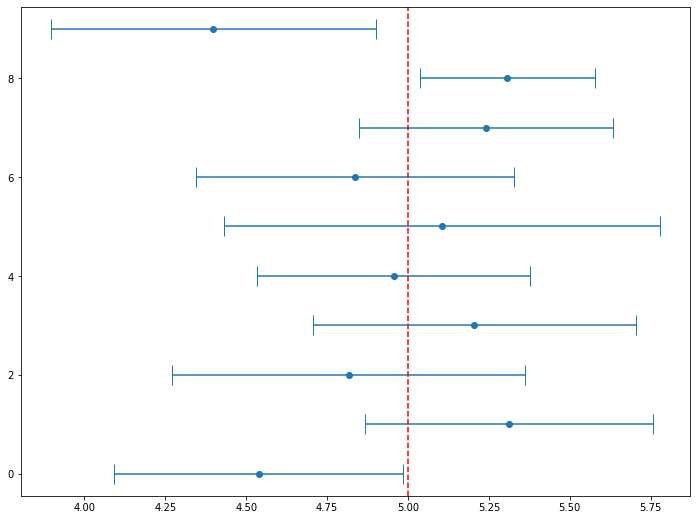

In [171]:
from scipy.stats import t

N = 10

m = 5
s2 = 2
pdf = norm(m, np.sqrt(s2))

p = 0
n = 0

T = 10

alpha = 0.31731050786291415
k = t.ppf(1 - alpha/2, N - 1)
x = []
xb = []
print(k)
for _ in range(T):
    samples = pdf.rvs(size=N)
    hs = np.sqrt(samples.var() * N / (N-1)) / np.sqrt(N)
    hm = samples.mean()
    
    x.append(hm)
    xb.append(k*hs)
    
    if hm - k*hs <= m <= hm + k*hs:
        p += 1
    else:
        n += 1

print(p/T)
print(1 - alpha)

y = [n for n in range(len(x))]
plt.errorbar(x, y, xerr=xb, fmt="o", capsize=10)
plt.axvline(m, ls='--', c='r')
plt.show()